In [1]:
import lmdb
import xml.etree.ElementTree as ET
import networkx as nx
from tqdm import tqdm
import numpy as np
import re
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

os.chdir('/Users/bebr1814/projects/wikipedia')
sns.set_context("talk") 

In [2]:
class WikipediaGame:
	def __init__(self, wiki_xml_path=None, graph_pkl=None):

		self.exclude_prefixes = ['Module:', 'Template:', 'Wikipedia:', 'MediaWiki:', 'Category:', 'File:', 'Help:', 'Portal:', 'Draft:', 'Book:', 'User:', 'Special:', 'TimedText:', 'Talk:', 'Wikipedia talk:', 'MediaWiki talk:', 'Category talk:', 'File talk:', 'Template talk:', 'Module talk:']

		# DB to store text
		self.lmdb_path = "wikipedia_db"
		if os.path.exists(self.lmdb_path) and graph_pkl is None:
			shutil.rmtree(self.lmdb_path, ignore_errors=True) # delete LMDB database if it exists
		self.lmdb_env = lmdb.open(self.lmdb_path, map_size=20**9)  # 2GB max size

		# DB to store vectors
		# This should be generated beforehand
		self.vec_lmdb_path = "vector_db"
		if os.path.exists(self.vec_lmdb_path):
			self.vec_env = lmdb.open(self.vec_lmdb_path, readonly=True, lock=False)
		else:
			self.vec_env = None


		if graph_pkl is not None:
			self.G = pickle.load(open(graph_pkl, "rb"))
			self.article_titles = set(self.G.nodes())
		elif wiki_xml_path is not None:
			self.wiki_xml = wiki_xml_path
			self.build_graph()
		else:
			raise ValueError("Either wiki_xml_path or graph must be provided")

		self.pagerank = nx.pagerank(self.G, alpha=0.85)
		self.betweenness = None
		# nx.betweenness_centrality(self.G, normalized=True, k=1000)

	def store_article(self,title, content):
		with self.lmdb_env.begin(write=True) as txn:
			txn.put(title.encode(), content.encode())  # Store title → full text

	def get_article(self,title):
		with self.lmdb_env.begin() as txn:
			data = txn.get(title.encode())
			return data.decode() if data else None  # Retrieve full text by title
	
	def get_vector(self, title):
		if self.vec_env is None:
			raise RuntimeError("Vector LMDB is not initialized. Make sure vector_db exists.")

		with self.vec_env.begin() as txn:
			data = txn.get(title.encode())
			if data is None:
				return None
			return np.frombuffer(data, dtype=np.float32)

	def build_graph(self):
		"""Build the directed graph from Wikipedia XML."""
		print("Parsing XML...")
		tree = ET.parse(self.wiki_xml)
		root = tree.getroot()
		
		# Initialize a directed graph
		self.G = nx.DiGraph()
		self.article_titles = set()
		
		print("Building graph and extracting text content...")

		# get all article titles
		for page in tqdm(root[1:]):
			title = page.find('{http://www.mediawiki.org/xml/export-0.11/}title').text
			if any(title.startswith(prefix) for prefix in self.exclude_prefixes) or title in ['Global']:
				continue
			self.article_titles.add(title)
		
		
		# Iterate over the XML tree
		for page in tqdm(root[1:]):
			# Get the title of the page
			title = page.find('{http://www.mediawiki.org/xml/export-0.11/}title').text
			if any(title.startswith(prefix) for prefix in self.exclude_prefixes):
				continue

			# Get the text of the page
			text_element = page.find('{http://www.mediawiki.org/xml/export-0.11/}revision').find('{http://www.mediawiki.org/xml/export-0.11/}text')
			
			if text_element is not None:

				text = text_element.text
				if text is None or text == '':
					self.article_titles.remove(title)
					# Remove any links to this article from the graph
					if self.G.has_node(title):
						self.G.remove_node(title)
					continue

				# Store the text content in the LMDB database
				self.store_article(title, self.clean_wikipedia_text(text))

				# Find all links in the text using regex
				try:
					links = re.findall(r'\[\[([^|\]]+)(?:\|[^\]]*)?\]\]', text)
					# Exclude links that aren't valid articles
					links = list(self.article_titles.intersection(links))
					
					# Add the links to the graph
					if len(links) > 0:
						for link in links:
							self.G.add_edge(title, link)
					else:
						# Add the node even if it has no outgoing links
						self.G.add_node(title)
				except Exception as e:
					print(f"{title} processing error: {e}")
			else:
				print(f"{title} has no text content")
		
		# print("Vectorizing all articles...")
		# self.vectorize_all()
		
		print(f"Graph built with {len(self.G.nodes())} nodes and {len(self.G.edges())} edges")
	
	def clean_wikipedia_text(self,text):
		
		# Remove {{templates}}
		text = re.sub(r"\{\{.*?\}\}", "", text)

		# Remove [[File:...]] and similar media references
		text = re.sub(r"\[\[File:.*?\]\]", "", text)

		# Remove section headers (== Title ==)
		text = re.sub(r"==+.*?==+", "", text)

		# Remove [[Category:...]] tags (if present in raw text)
		text = re.sub(r"\[\[Category:.*?\]\]", "", text)

		# Replace [[linked text|display text]] with just "display text"
		text = re.sub(r"\[\[([^|\]]+\|)?([^\]]+)\]\]", r"\2", text)

		# Remove all remaining [[brackets]] (if any)
		text = re.sub(r"\[\[|\]\]", "", text)

		# Remove extra whitespace and newlines
		text = re.sub(r"\s+", " ", text).strip()

		# Remove \'
		text = text.replace("\'", "")
		
		return text


In [3]:
wiki_game = WikipediaGame(graph_pkl='/Users/bebr1814/projects/wikipedia/pickles/simplewiki_full_graph.4.15.25.pkl')
wiki_game.betweenness = pickle.load(open('/Users/bebr1814/projects/wikipedia/pickles/simplewiki_full_graph.betweenness.pkl', "rb"))

## DataFrame

In [4]:
nodes = pd.DataFrame()
nodes['title'] = list(wiki_game.G.nodes())

In [5]:
# Get list of degrees
degrees = np.asarray([d for n, d in wiki_game.G.degree()])
in_degrees = np.asarray([d for n, d in wiki_game.G.in_degree()])
out_degrees = np.asarray([d for n, d in wiki_game.G.out_degree()])

# add to nodes
nodes['degree'] = degrees
nodes['in_degree'] = in_degrees
nodes['out_degree'] = out_degrees

nodes.head()

,title,degree,in_degree,out_degree
0,April,469,91,378
1,Pacific Ocean,879,864,15
2,2014,1019,504,515
3,Tanzania,370,330,40
4,1945,757,479,278


In [6]:
nodes['betweenness'] = nodes['title'].map(wiki_game.betweenness)
nodes.head()

,title,degree,in_degree,out_degree,betweenness
0,April,469,91,378,0.001830
1,Pacific Ocean,879,864,15,0.000261
2,2014,1019,504,515,0.002272
3,Tanzania,370,330,40,0.000110
4,1945,757,479,278,0.002163


## Node/Edge Counts

In [ ]:
n_nodes = wiki_game.G.number_of_nodes()

n_nodes

370152

In [8]:
n_edges = wiki_game.G.number_of_edges()
n_edges

3013038

## Degree Distribution

In [21]:
nodes[nodes['out_degree']==0]

,title,degree,in_degree,out_degree,betweenness
502,Lammas Day,1,1,0,0.0
561,Persia,248,248,0,0.0
562,Conservation (art),6,6,0,0.0
597,Air craft,1,1,0,0.0
693,Simba,11,11,0,0.0
...,...,...,...,...,...
370119,Rosario Grimani known as Saro,0,0,0,0.0
370134,Shamim Hossen,0,0,0,0.0
370135,Flag of San Juan de los Lagos,0,0,0,0.0
370147,Haritha Gogineni,0,0,0,0.0


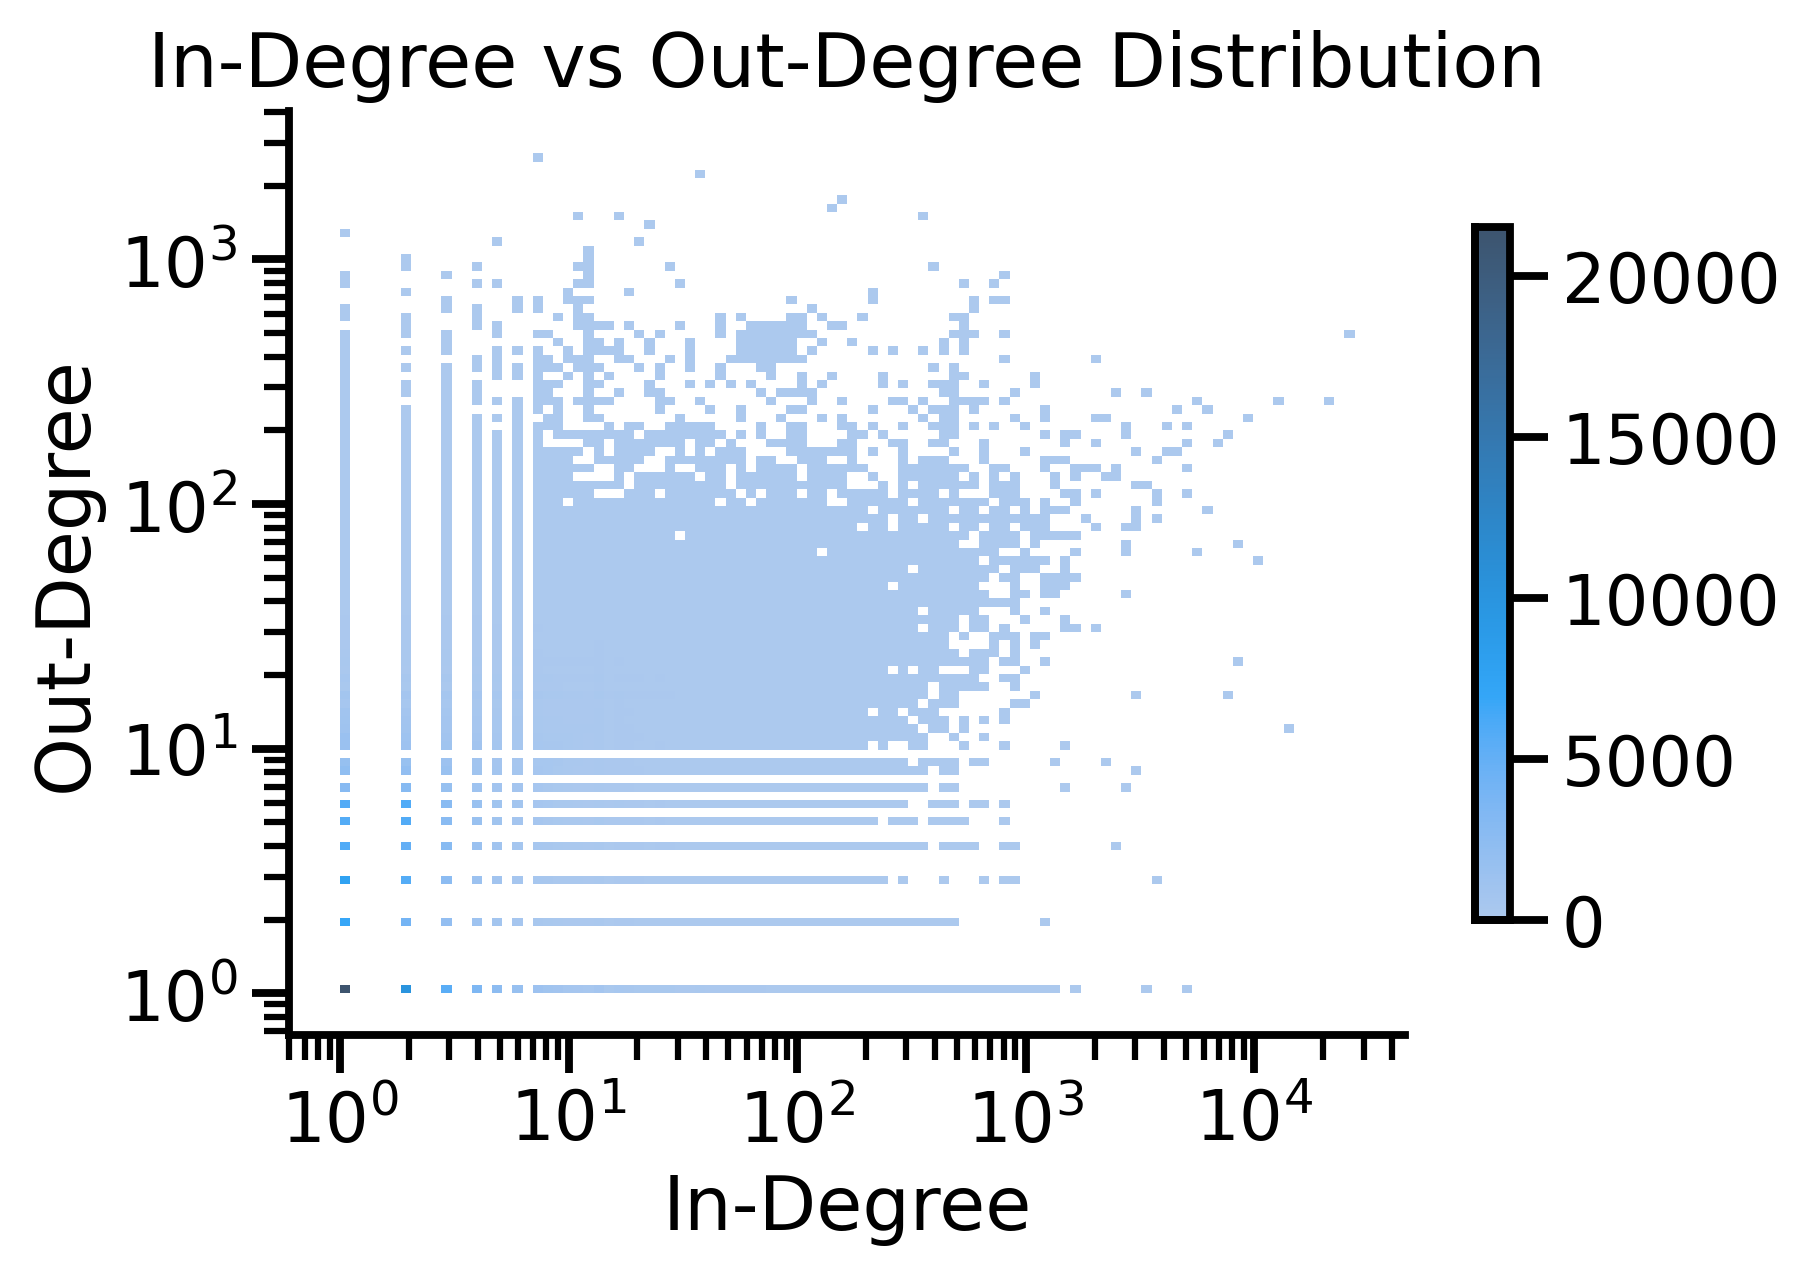

In [22]:
# Plot the distribution of in vs out degrees
fig,ax = plt.subplots(figsize=(6,4),dpi=300)
sns.histplot(data=nodes[(nodes['out_degree']>=1) & (nodes['in_degree']>=1)],x='in_degree',y='out_degree',ax=ax, log_scale=(True, True), cbar=True, cbar_kws=dict(shrink=.75), bins=100)
ax.set_xlabel('In-Degree')
ax.set_ylabel('Out-Degree')

ax.set_title('In-Degree vs Out-Degree Distribution')

sns.despine()
plt.show()

In [12]:
# print nodes with out-degree = 1 and in-degree > 1000
nodes[(nodes['out_degree'] == 1) & (nodes['in_degree'] > 1000)]

# Many nodes with out-degree == 1 are synonyms that redirect to the real article...

,title,degree,in_degree,out_degree,betweenness
3891,USA,1017,1016,1,2.507518e-04
6306,Federal Information Processing Standard,3426,3425,1,2.592472e-06
6311,List of sovereign states,5003,5002,1,1.769296e-05
19438,North American Central Time Zone,1319,1318,1,9.500094e-07
94365,Defender (football),1054,1053,1,5.696495e-07
95356,Bayerisches Landesamt für Statistik,1672,1671,1,3.465209e-07
136648,J. League Division 1,1236,1235,1,1.407556e-06


/Users/bebr1814/miniconda3/envs/pyda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7712/1014471789.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nodes['degree_ratio'].fillna(0, inplace=True)


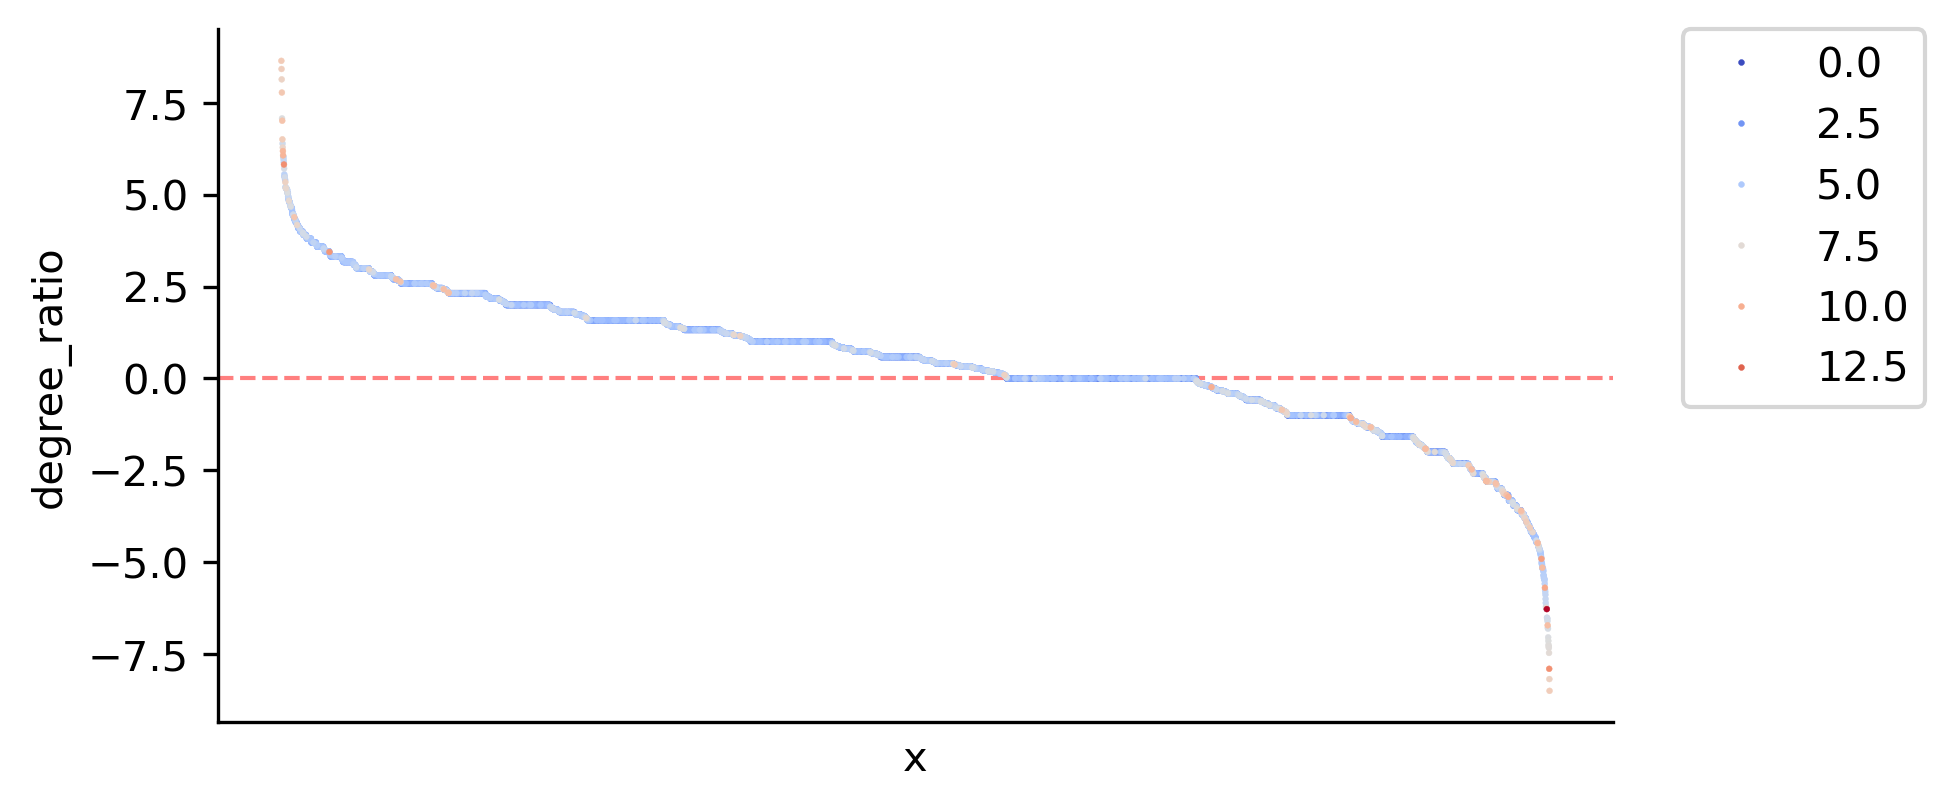

In [79]:
# Plot the difference between in and out degree on y vs article on x, sorting articles by the difference. Lineplot.
nodes['degree_ratio'] = np.log2( nodes['out_degree'] / nodes['in_degree'] )
nodes['degree_ratio'].fillna(0, inplace=True)

nodes['degree_log'] = np.log2(nodes['degree']+1)

fig,ax = plt.subplots(figsize=(6,3),dpi=300)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
sns.scatterplot(data=nodes.sample(10000).sort_values('degree_ratio', ascending=False).assign(x=lambda x: range(len(x))).sort_values('degree_log',ascending=True), x='x', y='degree_ratio',hue='degree_log',palette='coolwarm',s=2,edgecolor=None,zorder=999)
plt.xticks([],[])
# move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

plt.show()

## Betweenness Centrality

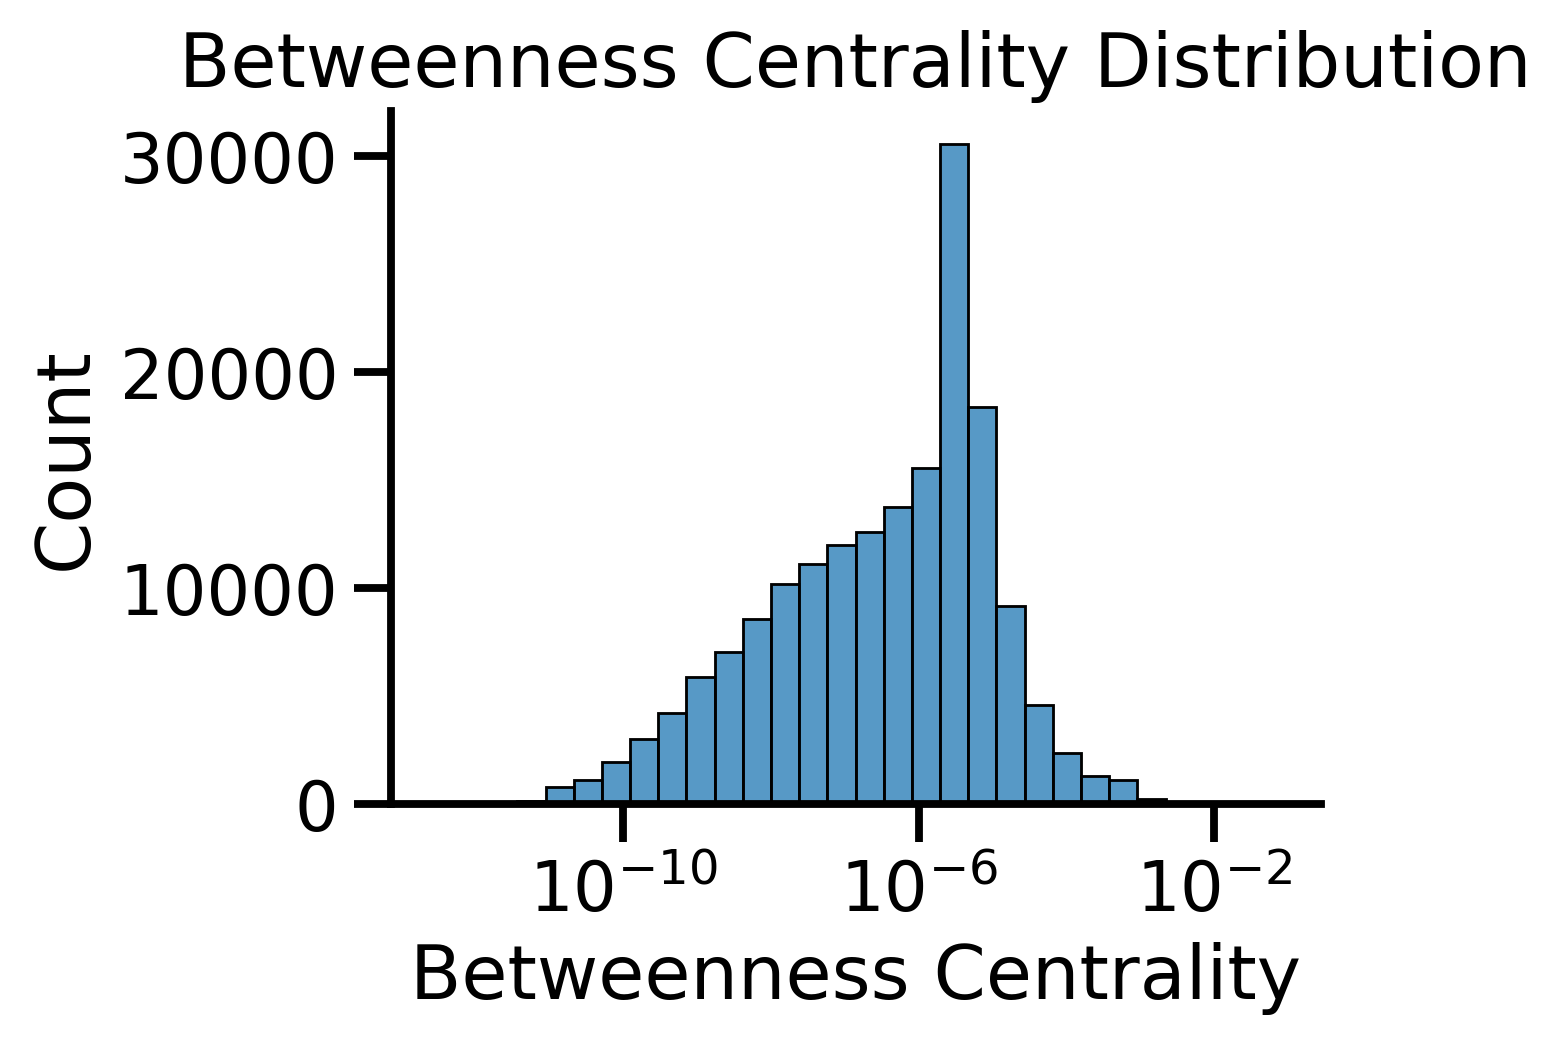

In [24]:
# Plot betweenness distribution
fig,ax = plt.subplots(figsize=(4,3),dpi=300)
sns.histplot(data=nodes, x='betweenness', ax=ax, log_scale=(True, False), bins=30)
ax.set_xlabel('Betweenness Centrality')
ax.set_ylabel('Count')
ax.set_title('Betweenness Centrality Distribution')
sns.despine()
plt.show()

## Geodesic Distances

In [14]:
# Grab the large component
largest_cc = max(nx.strongly_connected_components(wiki_game.G), key=len)
largest_cc = wiki_game.G.subgraph(largest_cc).copy()

In [ ]:
# # Calculate mean_geodesic_distance
# # Too slow, graph too big
# mean_geodesic_distance = nx.average_shortest_path_length(largest_cc)

# sample 1000 random pairs of nodes and collect the geodesic distances
distances = []
pairs = np.random.choice(largest_cc.nodes(), size=(100000, 2), replace=False)
for pair in tqdm(pairs):
	try:
		distance = nx.shortest_path_length(largest_cc, source=pair[0], target=pair[1])
		distances.append(distance)
	except nx.NetworkXNoPath:
		pass

print(f"Mean geodesic distance: {np.mean(distances)}")

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:54<00:00, 1845.75it/s]

Mean geodesic distance: 5.71306


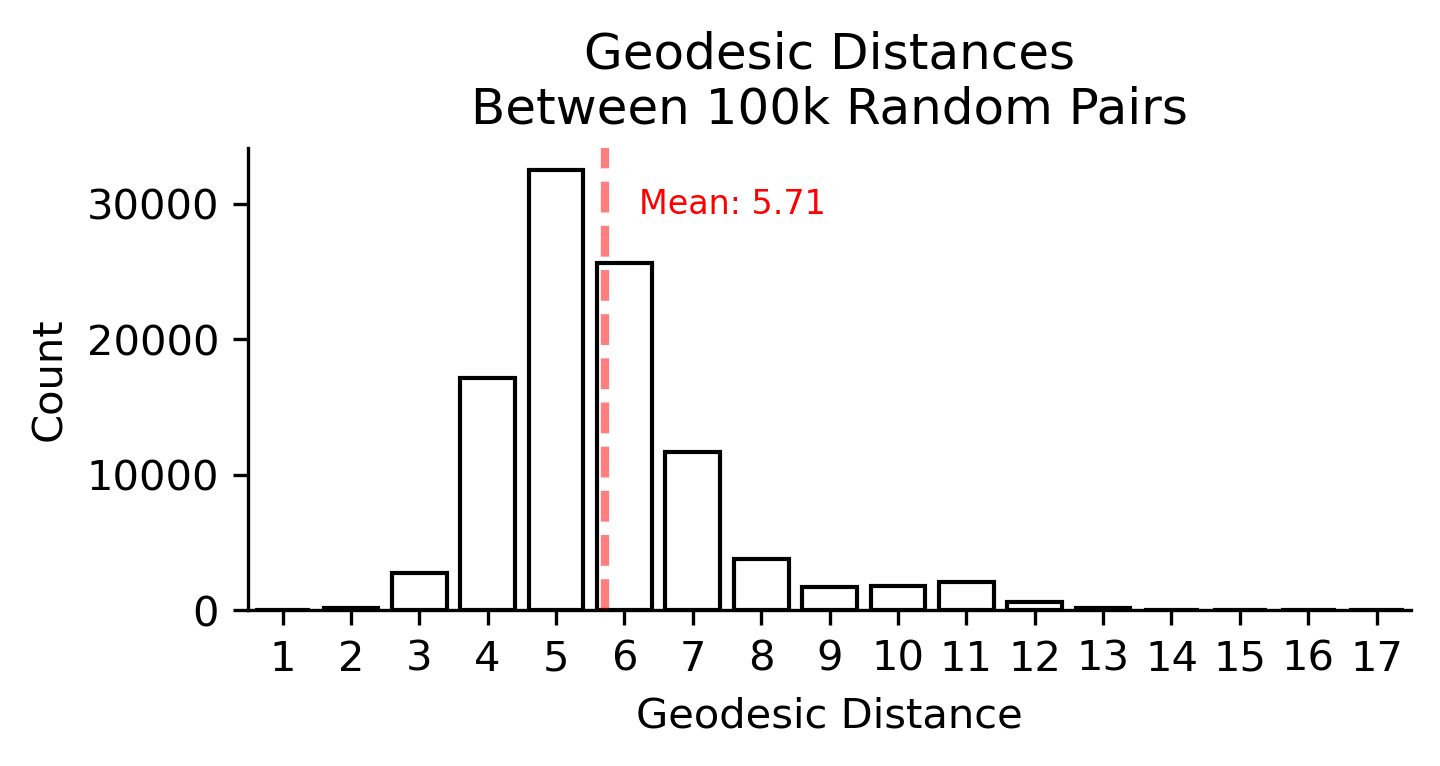

In [60]:
# Plot distances
dist_df = pd.DataFrame(distances)
dist_df.columns = ['distance']

fig,ax = plt.subplots(figsize=(5,2),dpi=300)
# countplot
sns.countplot(data=dist_df, x='distance', ax=ax, color='white', edgecolor='black', linewidth=1)
# Plot mean as vertical line
ax.axvline(x=np.mean(distances)-1, color='red', linestyle='--', linewidth=2, alpha=0.5)
# Label mean
ax.text(np.mean(distances)-0.5, 30000, f'Mean: {np.mean(distances):.2f}', color='red', fontsize=8, ha='left', va='center')
ax.set_xlabel('Geodesic Distance')
ax.set_ylabel('Count')
ax.set_title('Geodesic Distances\nBetween 100k Random Pairs')

sns.despine()

## Model Performance

In [88]:
perf = pd.read_csv('pairs_stats.csv')
perf.head()

,Source,Target,My path length,Heuristic path,Heuristic path length,Heuristic time,ML path,ML path length,ML time,RL path,RL path length,RL time
0,Aaron Clauset,Paul Erdős,3,"['Aaron Clauset', 'Physics', 'Albert Einstein'...",36.0,1.253698,"['Aaron Clauset', 'Computer science', 'List of...",15.0,3.027043,"['Aaron Clauset', 'Physics', ""List of Jupiter'...",37.0,26.434564
1,Linux,Fred Rogers,11,"['Linux', 'List of Linux distributions', 'Pola...",51.0,1.470259,"['Linux', 'Linux Mint', 'Advanced Packaging To...",51.0,10.388906,"['Linux', 'List of Linux distributions', 'Pola...",51.0,34.977975
2,Wasabi,Adobe Inc.,22,"['Wasabi', 'Japan', 'United States', 'Ronald R...",51.0,1.727856,"['Wasabi', 'New Zealand', 'Unitary state', 'Ni...",51.0,6.835197,"['Wasabi', 'Japan', 'United States', 'Ronald R...",51.0,34.508489
3,Red (Taylor Swift album),Ulysses (novel),7,"['Red (Taylor Swift album)', 'Taylor Swift', '...",51.0,1.662778,"['Red (Taylor Swift album)', 'Americans', 'Uni...",51.0,8.166886,"['Red (Taylor Swift album)', 'Taylor Swift', '...",51.0,33.562705
4,Batman,FC Bayern Munich,5,"['Batman', 'DC Extended Universe', 'DC Comics'...",7.0,0.064375,"['Batman', 'Batman v Superman: Dawn of Justice...",51.0,8.481047,"['Batman', 'DC Extended Universe', 'DC Comics'...",40.0,29.080184


In [89]:
# For each method, check whether the goal was reached
for method in ['Heuristic','ML','RL']:
	# is the last item in path equal to the target?
	for i,r in perf.iterrows():
		perf.loc[i,f'{method} success'] = eval(r[f'{method} path'])[-1] == r['Target']
		perf.loc[i,f'{method} timeout'] = len(eval(r[f'{method} path'])) == 51


perf

,Source,Target,My path length,Heuristic path,Heuristic path length,Heuristic time,ML path,ML path length,ML time,RL path,RL path length,RL time,Heuristic success,Heuristic timeout,ML success,ML timeout,RL success,RL timeout
0,Aaron Clauset,Paul Erdős,3,"['Aaron Clauset', 'Physics', 'Albert Einstein'...",36.0,1.253698,"['Aaron Clauset', 'Computer science', 'List of...",15.0,3.027043,"['Aaron Clauset', 'Physics', ""List of Jupiter'...",37.0,26.434564,True,False,True,False,True,False
1,Linux,Fred Rogers,11,"['Linux', 'List of Linux distributions', 'Pola...",51.0,1.470259,"['Linux', 'Linux Mint', 'Advanced Packaging To...",51.0,10.388906,"['Linux', 'List of Linux distributions', 'Pola...",51.0,34.977975,False,True,False,True,False,True
2,Wasabi,Adobe Inc.,22,"['Wasabi', 'Japan', 'United States', 'Ronald R...",51.0,1.727856,"['Wasabi', 'New Zealand', 'Unitary state', 'Ni...",51.0,6.835197,"['Wasabi', 'Japan', 'United States', 'Ronald R...",51.0,34.508489,False,True,False,True,False,True
3,Red (Taylor Swift album),Ulysses (novel),7,"['Red (Taylor Swift album)', 'Taylor Swift', '...",51.0,1.662778,"['Red (Taylor Swift album)', 'Americans', 'Uni...",51.0,8.166886,"['Red (Taylor Swift album)', 'Taylor Swift', '...",51.0,33.562705,False,True,False,True,False,True
4,Batman,FC Bayern Munich,5,"['Batman', 'DC Extended Universe', 'DC Comics'...",7.0,0.064375,"['Batman', 'Batman v Superman: Dawn of Justice...",51.0,8.481047,"['Batman', 'DC Extended Universe', 'DC Comics'...",40.0,29.080184,True,False,False,True,True,False
5,Entropy,Tuberculosis,9,"['Entropy', 'Thermodynamic entropy', 'Earth', ...",51.0,1.836018,"['Entropy', 'Information entropy', 'Thermodyna...",51.0,9.675905,"['Entropy', 'Thermodynamic entropy', 'Earth', ...",51.0,28.869218,False,True,False,True,False,True
6,Brooklyn,Tom and Jerry,13,"['Brooklyn', 'New York City', 'United States',...",51.0,1.602427,"['Brooklyn', 'New York City', 'Morgan Stanley'...",51.0,8.174529,"['Brooklyn', 'New York City', 'United States',...",51.0,29.712728,False,True,False,True,False,True
7,Frédéric Chopin,Ganymede (moon),7,"['Frédéric Chopin', 'France', 'ISO 4217', 'Uni...",15.0,0.453630,"['Frédéric Chopin', 'Poland', 'Christianity', ...",51.0,8.588700,"['Frédéric Chopin', 'France', 'ISO 4217', 'Cou...",16.0,11.389576,True,False,False,True,True,False
8,Rockhole frog,Alps,5,"['Rockhole frog', 'Australia', 'United States'...",11.0,0.270896,"['Rockhole frog', 'Australia', 'United States'...",5.0,1.068968,"['Rockhole frog', 'Australia', 'United States'...",11.0,5.244258,True,False,True,False,True,False
9,Peach (color),Tokyo,5,"['Peach (color)', 'China', 'France', 'Belgium'...",8.0,0.080619,"['Peach (color)', 'English language', 'United ...",9.0,1.892816,"['Peach (color)', 'English language', 'United ...",6.0,1.310228,True,False,True,False,True,False


In [129]:
import pandas as pd

# Base columns
base_cols = ['Source', 'Target', 'My path length']

# Methods and metrics
methods = ['Heuristic', 'ML', 'RL']
metrics = ['path', 'path length', 'time', 'success', 'timeout']

# Collect method-specific DataFrames
method_dfs = []

for method in methods:
    method_cols = [f"{method} {metric}" for metric in metrics]
    df = perf[base_cols + method_cols].copy()
    df.columns = base_cols + metrics
    df['method'] = method
    method_dfs.append(df)

# Create "Manual" method rows from base columns
my_df = perf[base_cols].copy()
my_df['method'] = 'Manual'
my_df['path'] = None
my_df['path length'] = my_df['My path length']
my_df['time'] = 0
my_df['success'] = True
my_df['timeout'] = False
my_df = my_df.drop(columns=['My path length'])

# Create "Shortest" method rows
shortest_df = perf[base_cols].copy()
shortest_df['method'] = 'Shortest'
shortest_df['path'] = perf.apply(lambda x: nx.shortest_path(wiki_game.G, source=x['Source'], target=x['Target']), axis=1)
shortest_df['path length'] = shortest_df['path'].apply(len)
shortest_df['time'] = 0
shortest_df['success'] = True
shortest_df['timeout'] = False

# Combine all rows
perf_long = pd.concat([shortest_df] + [my_df] + method_dfs, ignore_index=True)

# Reorder columns
ordered_cols = ['Source', 'Target', 'method', 'path', 'path length', 'time', 'success', 'timeout']
perf_long = perf_long[ordered_cols]

print(perf_long.head())


                     Source            Target    method  \
0             Aaron Clauset        Paul Erdős  Shortest   
1                     Linux       Fred Rogers  Shortest   
2                    Wasabi        Adobe Inc.  Shortest   
3  Red (Taylor Swift album)   Ulysses (novel)  Shortest   
4                    Batman  FC Bayern Munich  Shortest   

                                                path  path length  time  \
0  [Aaron Clauset, Physics, William Rowan Hamilto...          5.0   0.0   
1                    [Linux, KDE, 2001, Fred Rogers]          4.0   0.0   
2  [Wasabi, Japan, Nintendo, Adobe Flash, Adobe I...          5.0   0.0   
3  [Red (Taylor Swift album), The Daily Telegraph...          5.0   0.0   
4      [Batman, MSN, 1995, May 25, FC Bayern Munich]          5.0   0.0   

  success timeout  
0    True   False  
1    True   False  
2    True   False  
3    True   False  
4    True   False  


In [130]:
perf_long['Pair'] = perf_long['Source'] + ' -> ' + perf_long['Target']

In [131]:
method_palette = {
    'Shortest': '#000000',       # Black
    'Manual':   '#d62728',       # Red
    'Heuristic':'#2ca02c',       # Green
    'ML':       '#ff7f0e',       # Orange
    'RL':       '#1f77b4'        # Muted blue
}

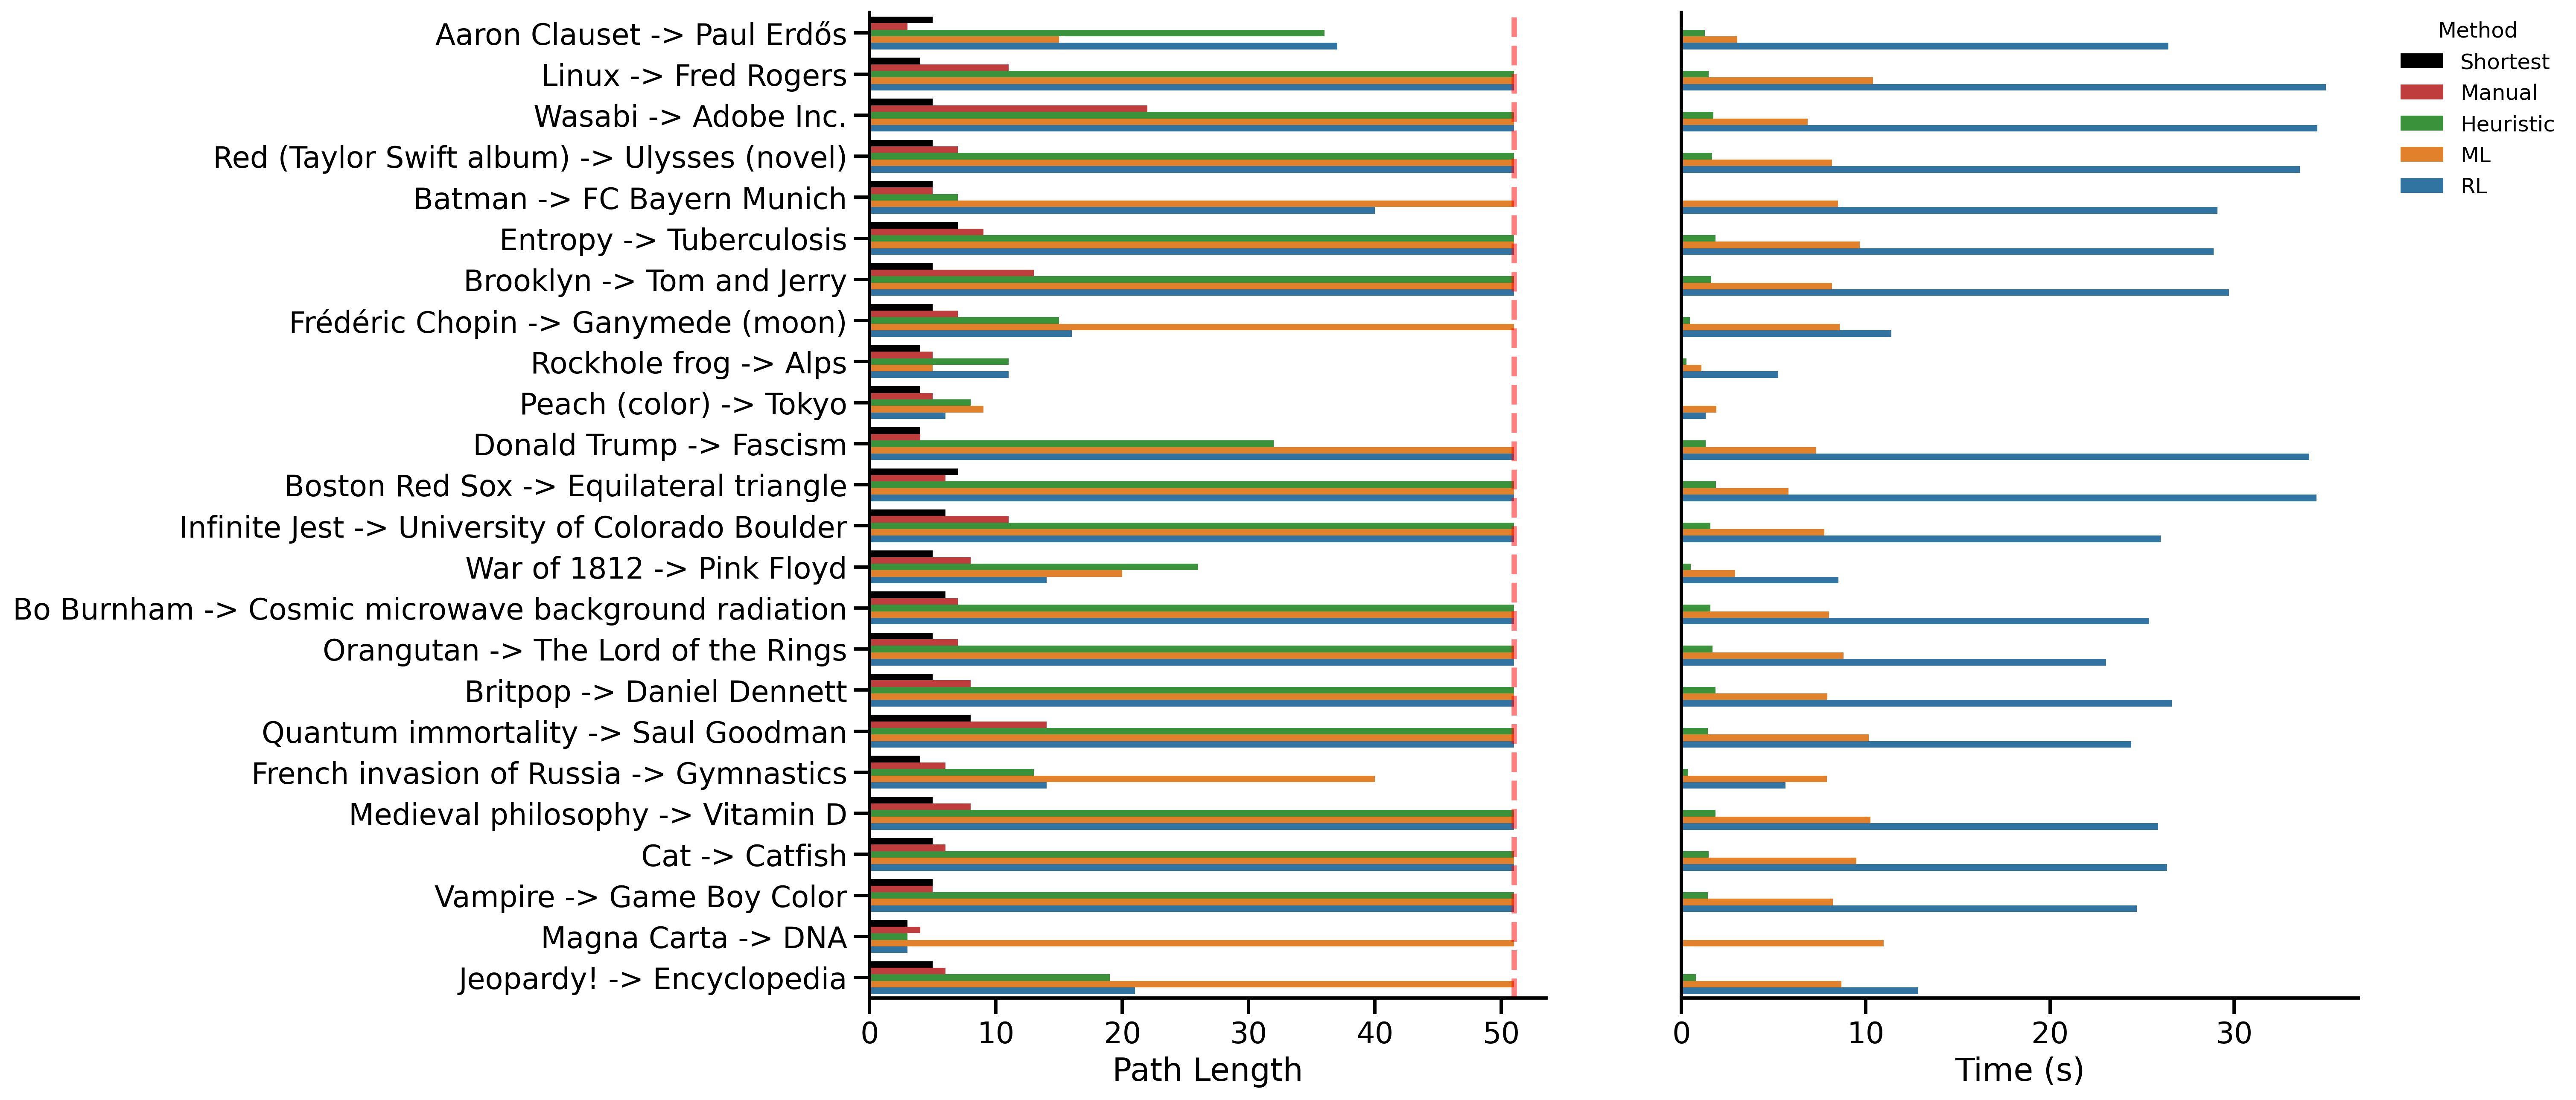

In [132]:
# plot the path length for each method for each pair
fig,axes = plt.subplots(1,2,figsize=(15,10),dpi=300)

axes = axes.flatten()

ax = axes[0]
sns.barplot(data=perf_long, y='Pair', x='path length', hue='method', ax=ax, palette=method_palette, dodge=True)
ax.set_ylabel('')
ax.set_xlabel('Path Length')
ax.axvline(x=51, color='red', linestyle='--', linewidth=3, alpha=0.5)
ax.legend().remove()

ax = axes[1]
sns.barplot(data=perf_long, y='Pair', x='time', hue='method', ax=ax, palette=method_palette, dodge=True)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xlabel('Time (s)')

# legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12, title='Method', title_fontsize='12', frameon=False)
sns.despine()



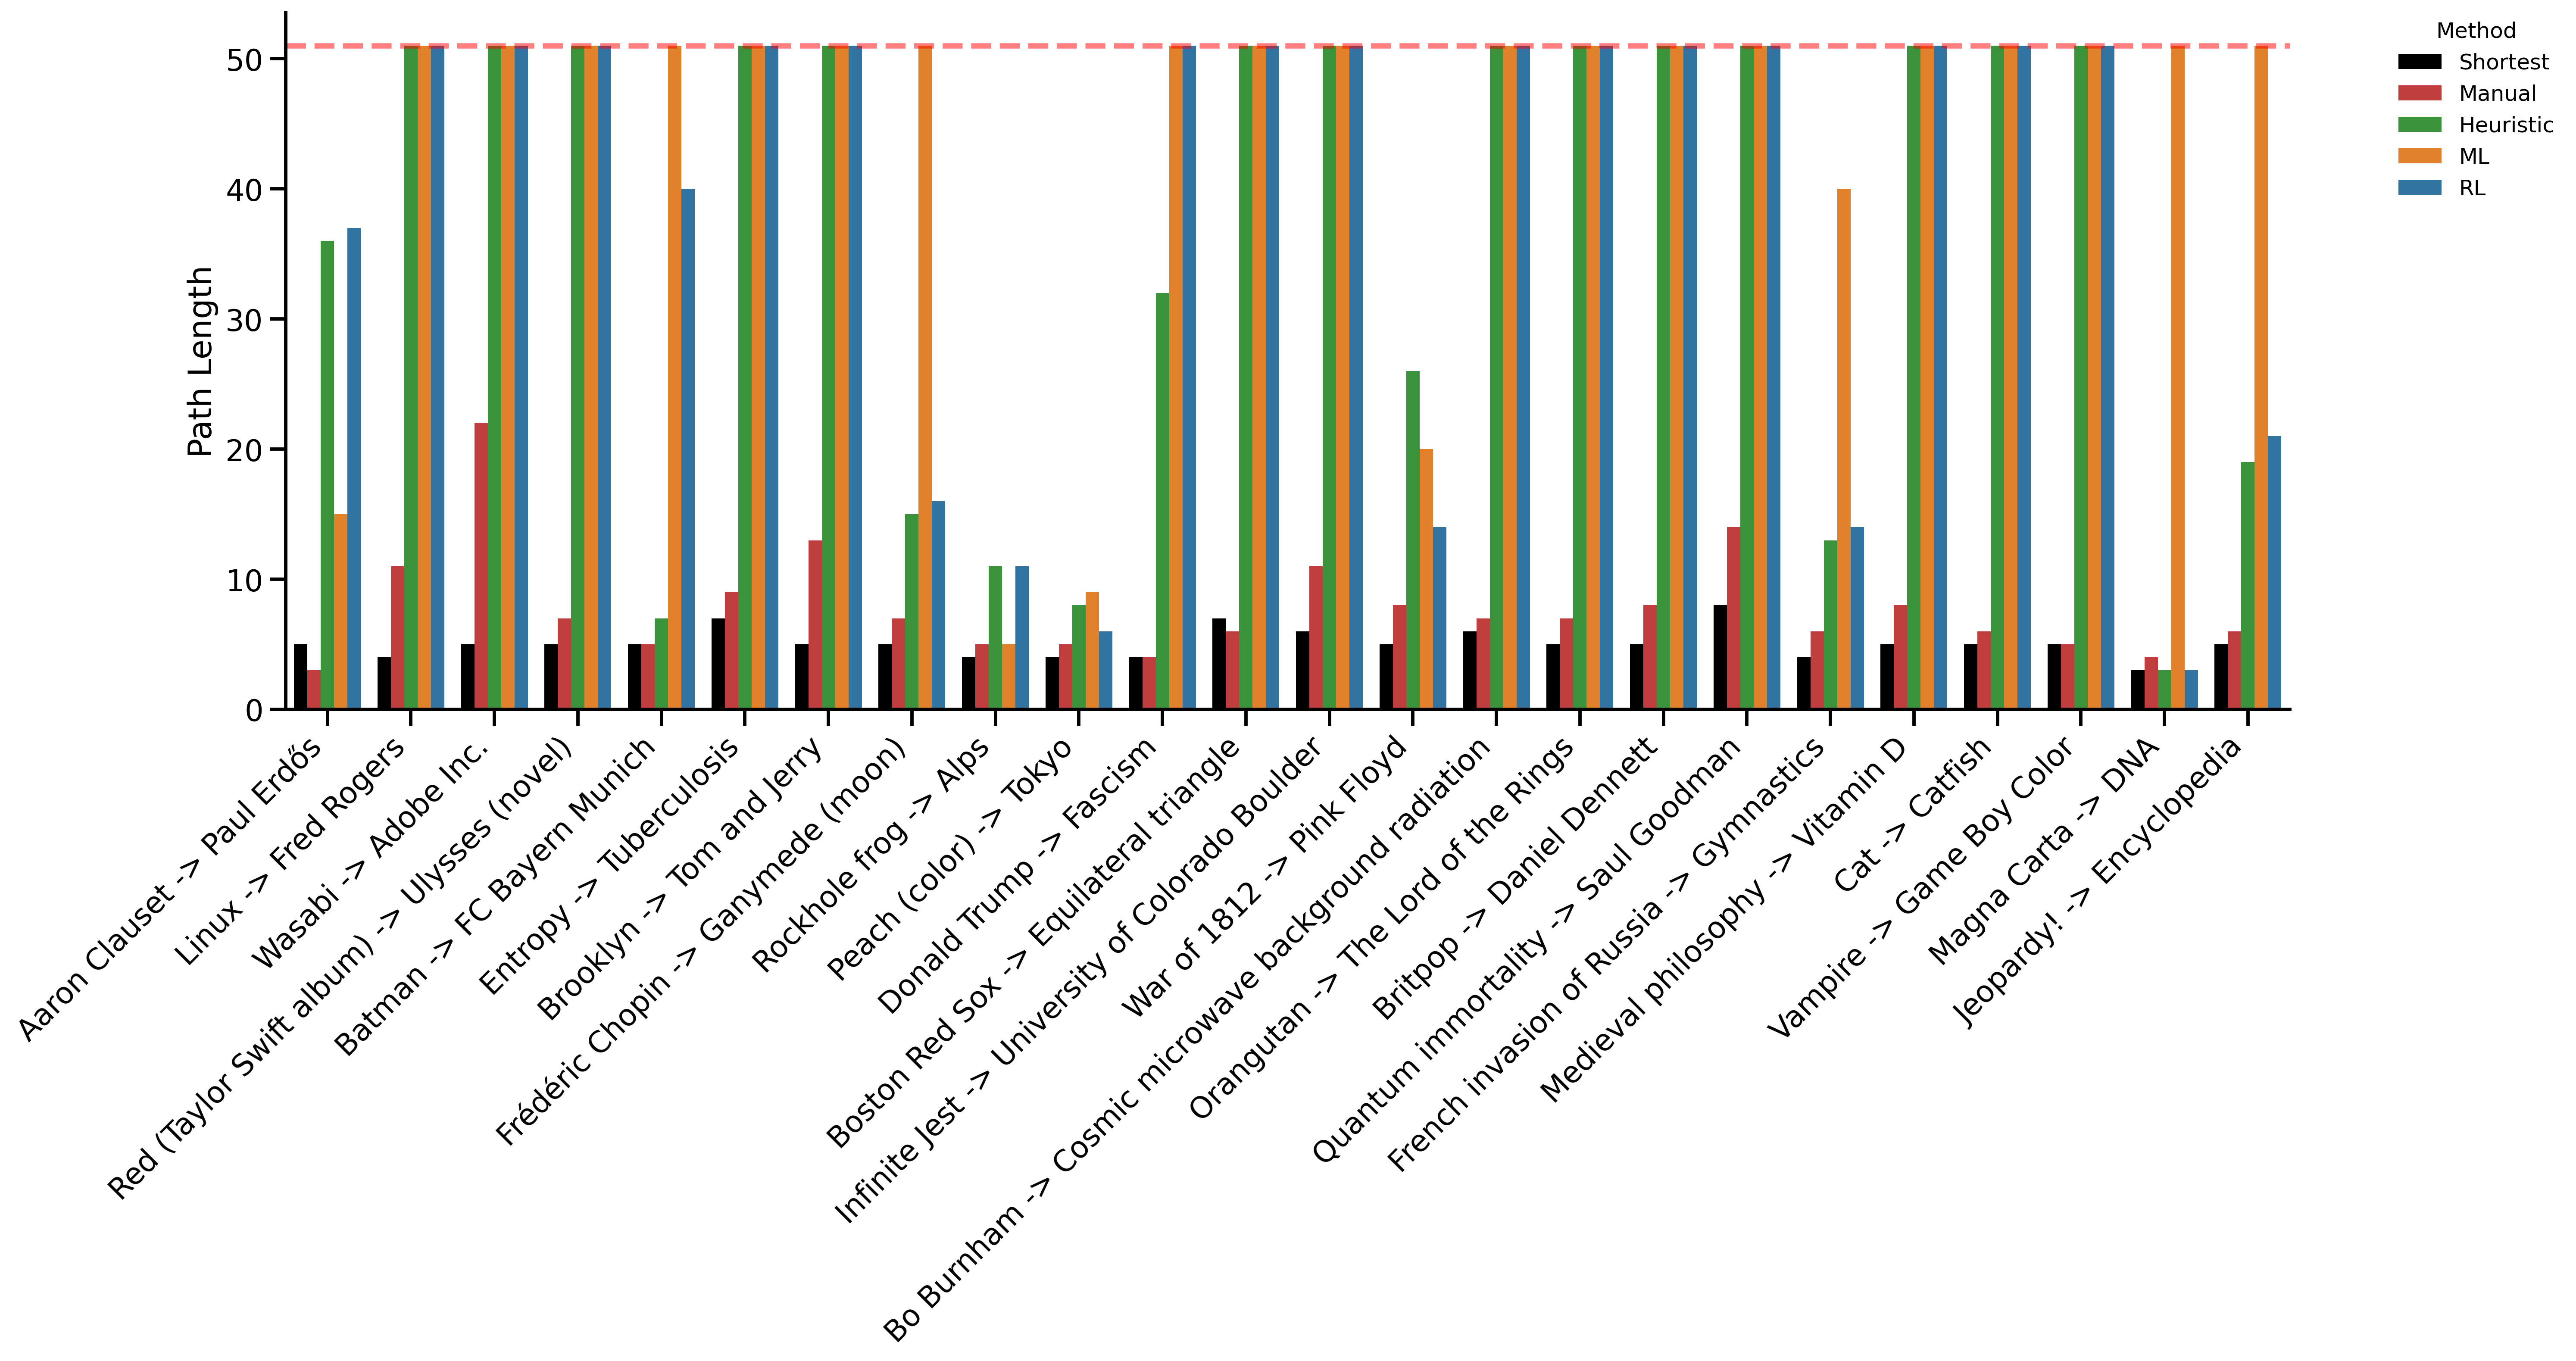

In [154]:
# plot the path length for each method for each pair
fig,ax = plt.subplots(figsize=(20,7),dpi=300)

# sns.barplot(data=perf_long, y='Pair', x='path length', hue='method', ax=ax, palette=method_palette, dodge=True)
sns.barplot(data=perf_long, x='Pair', y='path length', hue='method', ax=ax, palette=method_palette, dodge=True)
ax.set_xlabel('')
ax.set_ylabel('Path Length')
plt.xticks(rotation=45, ha='right')
# ax.axvline(x=51, color='red', linestyle='--', linewidth=3, alpha=0.5)
ax.axhline(y=51, color='red', linestyle='--', linewidth=3, alpha=0.5)
# legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12, title='Method', title_fontsize='12', frameon=False)
sns.despine()
plt.show()


/tmp/ipykernel_23274/1957002552.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_long, y='method', x='success', ax=ax, palette=method_palette, errorbar='se')
/tmp/ipykernel_23274/1957002552.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_long, y='method', x='path length', ax=ax, palette=method_palette, errorbar='se')
/tmp/ipykernel_23274/1957002552.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_long[perf_long['timeout'] == False], y='method', x='path length', ax=ax, palette=method_palette, errorbar

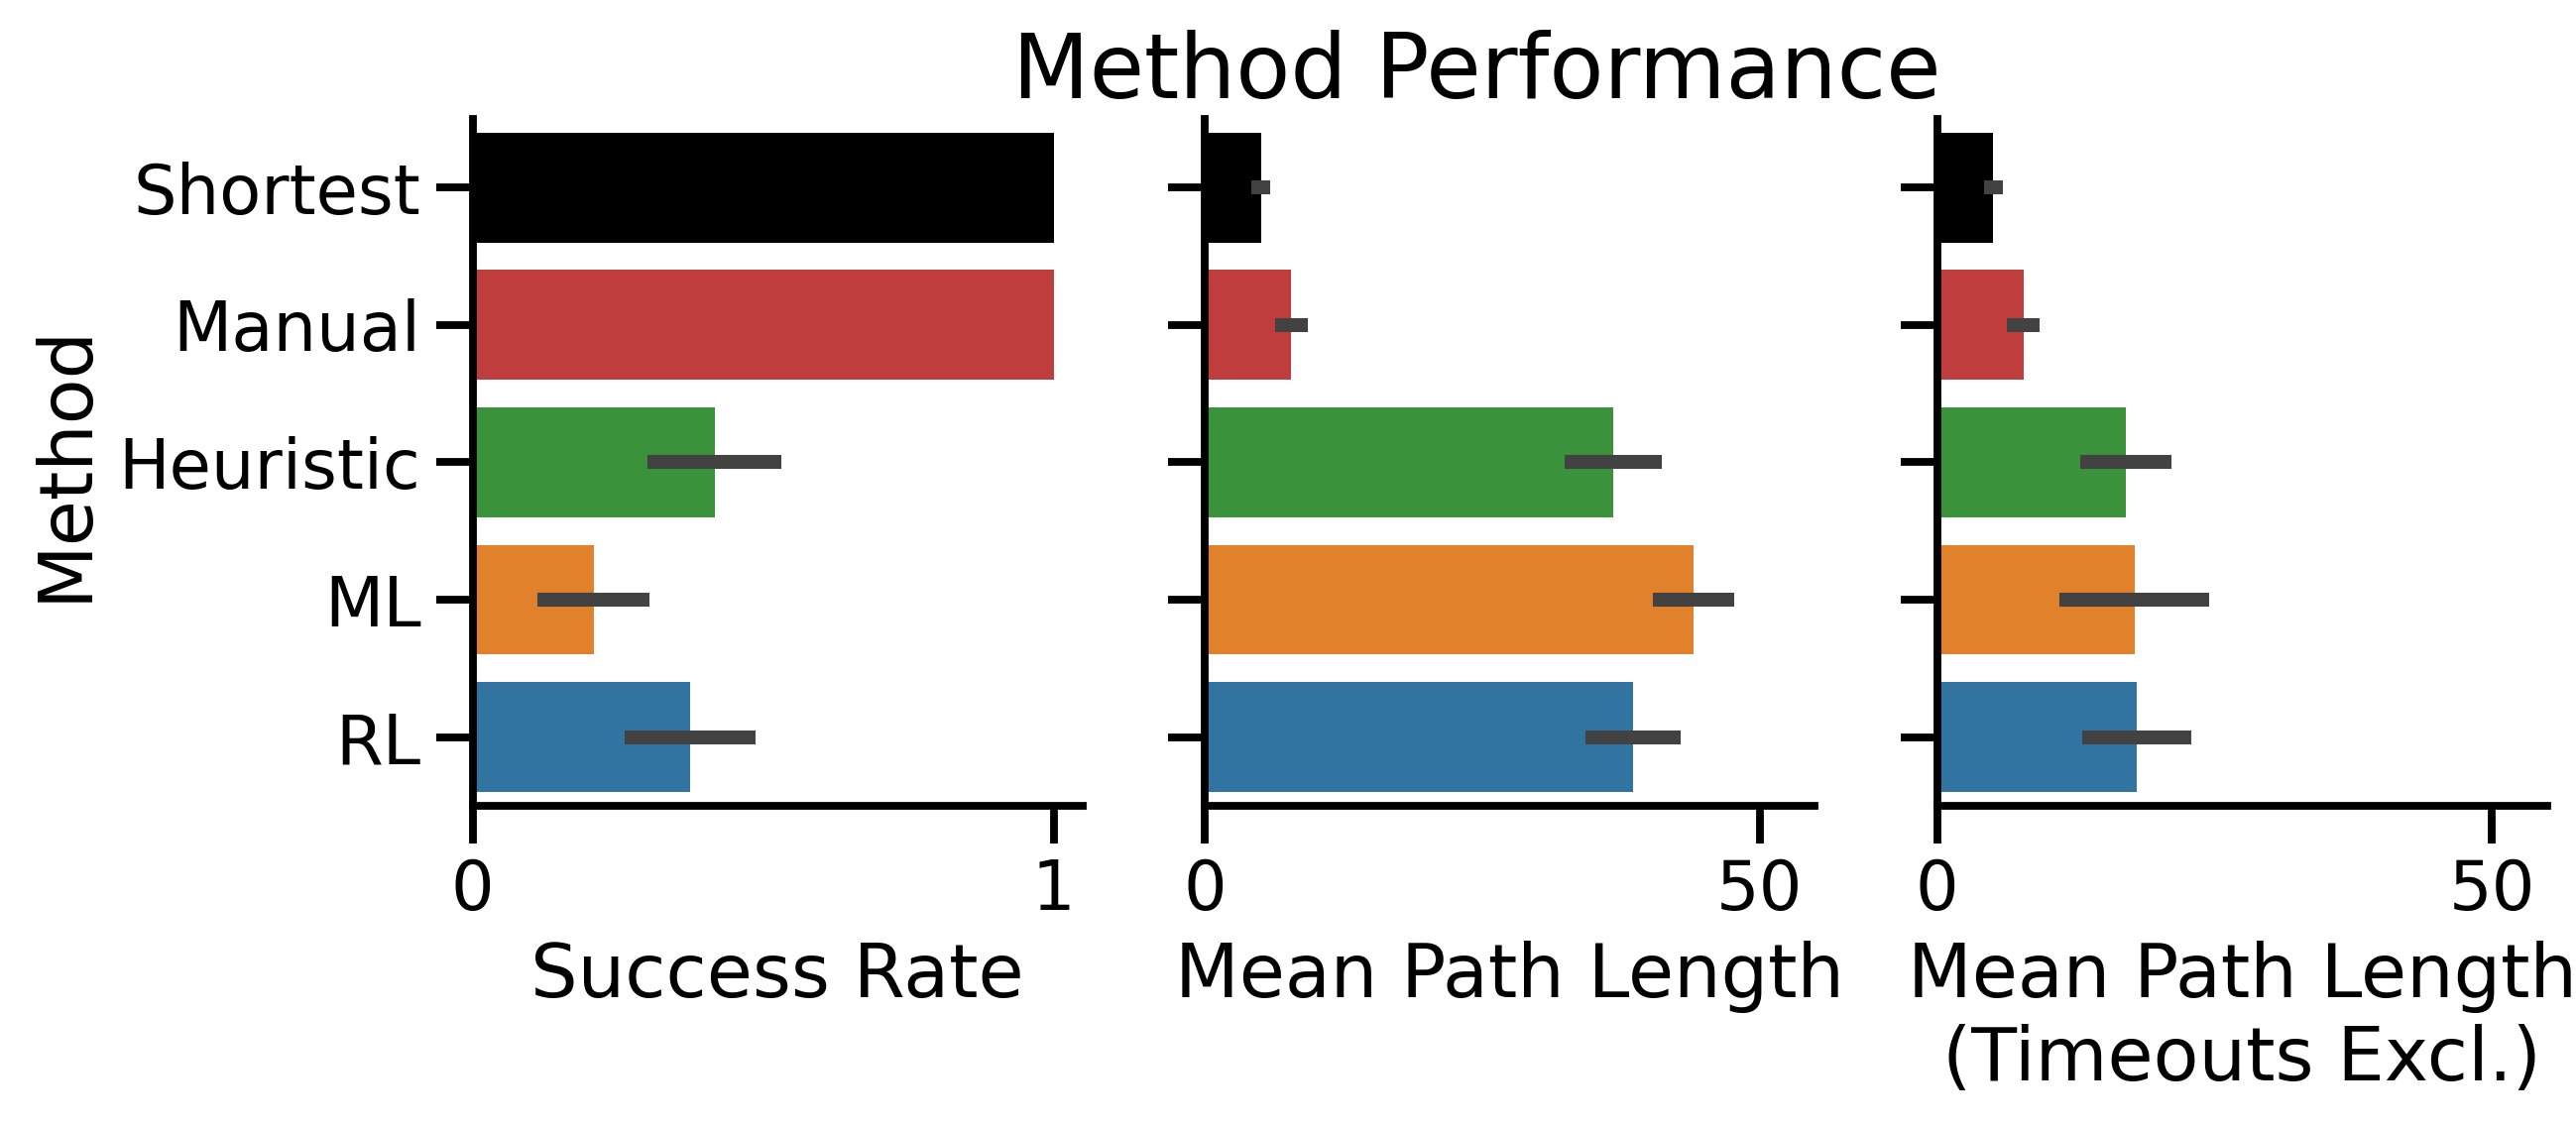

In [153]:
# Plot the number of successes by method
fig,axes = plt.subplots(1,3,figsize=(9,3),dpi=300,sharey=True)
axes = axes.flatten()

ax = axes[0]
sns.barplot(data=perf_long, y='method', x='success', ax=ax, palette=method_palette, errorbar='se')
ax.set_xlabel('Success Rate')
ax.set_ylabel('Method')

ax = axes[1]
sns.barplot(data=perf_long, y='method', x='path length', ax=ax, palette=method_palette, errorbar='se')
ax.set_xlabel('Mean Path Length')
ax.set_xlim(0,55)

ax = axes[2]
sns.barplot(data=perf_long[perf_long['timeout'] == False], y='method', x='path length', ax=ax, palette=method_palette, errorbar='se')
ax.set_xlabel('Mean Path Length\n(Timeouts Excl.)')
ax.set_xlim(0,55)

plt.suptitle('Method Performance')

sns.despine()
plt.show()

In [181]:
perf.iloc[8,:]

Source                                                       Rockhole frog
Target                                                                Alps
My path length                                                           5
Heuristic path           ['Rockhole frog', 'Australia', 'United States'...
Heuristic path length                                                 11.0
Heuristic time                                                    0.270896
ML path                  ['Rockhole frog', 'Australia', 'United States'...
ML path length                                                         5.0
ML time                                                           1.068968
RL path                  ['Rockhole frog', 'Australia', 'United States'...
RL path length                                                        11.0
RL time                                                           5.244258
Heuristic success                                                     True
Heuristic timeout        

In [182]:
# Print the optimal path and then the path of each method

def print_path(path):
	for p in path:
		print(p,end='\n')

# for i,r in perf.iterrows():
r = perf.iloc[8,:]
print(f"Source: {r['Source']}, Target: {r['Target']}")
print(f"Shortest path:")
print_path(nx.shortest_path(wiki_game.G, source=r['Source'], target=r['Target']))
print('\nHeuristic path:')
print_path(eval(r['Heuristic path']))
print('\nML path:')
print_path(eval(r['ML path']))
print('\nRL path:')
print_path(eval(r['RL path']))

Source: Rockhole frog, Target: Alps
Shortest path:
Rockhole frog
Australia
Italy
Alps

Heuristic path:
Rockhole frog
Australia
United States
Ronald Reagan
Chicago
List of United States cities by population
Kansas
Academy Award for Best Actor
2012 in movies
Deaths in 2012
Alps

ML path:
Rockhole frog
Australia
United States
France
Alps

RL path:
Rockhole frog
Australia
United States
Ronald Reagan
Chicago
List of United States cities by population
Kansas
Academy Award for Best Actor
2012 in movies
Deaths in 2012
Alps


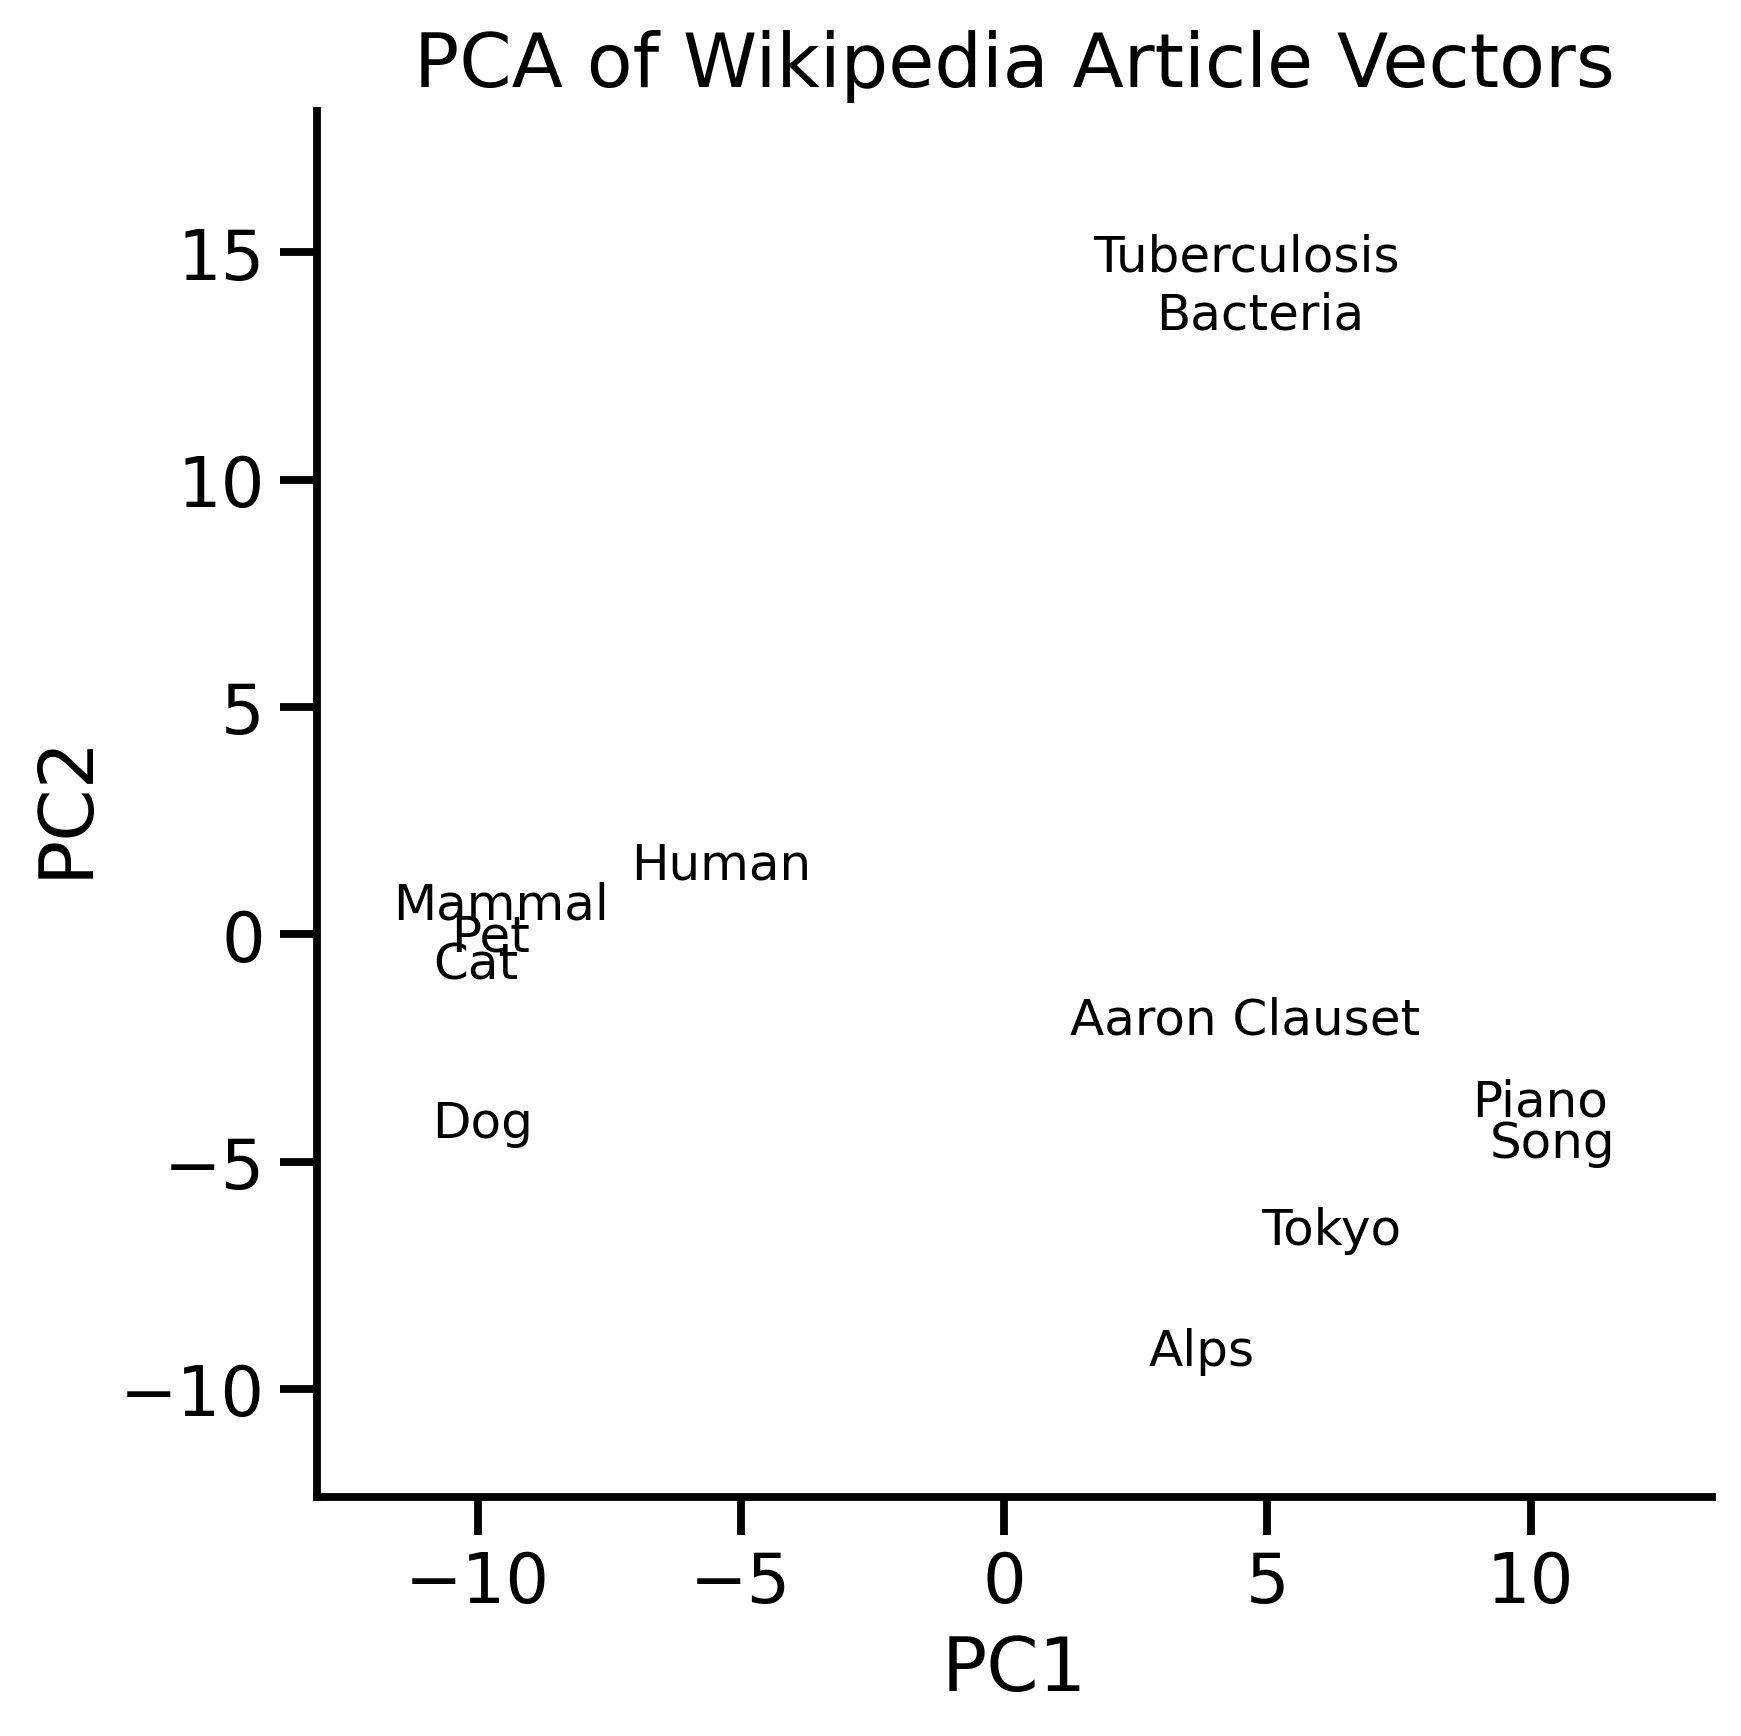

In [174]:
# Grab the semantic vectors for some articles
articles = ['Cat','Piano','Dog','Pet','Mammal','Bacteria','Alps','Song','Human','Tuberculosis','Tokyo','Aaron Clauset']

vectors = {}
for article in articles:
	vectors[article] = wiki_game.get_vector(article)

# PCA and plot the vectors with labels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the vectors
scaler = StandardScaler()
X = scaler.fit_transform(list(vectors.values()))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['label'] = articles

fig,ax = plt.subplots(figsize=(6,6),dpi=300)
sns.scatterplot(data=df, x='PC1', y='PC2', ax=ax, s=0, color='black')
for i in range(len(df)):
	ax.text(df['PC1'][i], df['PC2'][i], df['label'][i], fontsize=12, ha='center', va='center')

ax.set_xlim(ax.get_xlim()[0]-2, ax.get_xlim()[1]+2)
ax.set_ylim(ax.get_ylim()[0]-2, ax.get_ylim()[1]+2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of Wikipedia Article Vectors')
sns.despine()
plt.show()